# **Study of the effect of back translation as a preprocessing step on intent classification performances**

Back translated dataset and trained models have already been saved.

In [ ]:
# Install dependances
!pip install datasets
!pip install transformers
!pip3 install torch torchvision torchaudio
!pip install evaluate
!pip install sklearn

In [ ]:
from datasets import list_datasets, load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch 
import seaborn as sns
import numpy as np
import evaluate
import sklearn
import pandas as pd
import pickle

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
dataset = load_dataset('snips_built_in_intents', split='train')
dataset = dataset.train_test_split(test_size=0.2, seed=100, stratify_by_column="label")
print(dataset["train"][:10])

Generating train split:   0%|          | 0/328 [00:00<?, ? examples/s]

Dataset snips_built_in_intents downloaded and prepared to /root/.cache/huggingface/datasets/snips_built_in_intents/default/0.0.0/f7f10213b60cb830d41cb190315da7151437d62acb6f21f0159f7afb4cb7c784. Subsequent calls will reuse this data.
{'text': ['Book a table for Sophie and me at the Red Lobster tonight', "Tell my friends what time I'll get there", "Make a reservation for 4 people for today's lunch at a Starbucks nearby", 'I want the weather in Paris', 'Find me an outdoor table at Five leaves for 3', "I need a taxi for 6 to go to Audrey and Sam's wedding", "Book a table for friday 8pm for 2 people at Katz's Delicatessen", "Show me the way to Rand's birthday party by car", 'Get me a spot at Ippudo for lunch', 'Is there a wifi at The Smile?'], 'label': [7, 9, 7, 2, 7, 1, 7, 8, 7, 4]}


In [ ]:
def show_repartition():
  total_instances = sum([len(split) for split in dataset.values()])
  print("Data repartition:")

  for split_name in dataset:
    print(f"\t{split_name} instances: {len(dataset[split_name])} ({int(100*len(dataset[split_name])/total_instances)}%)")

show_repartition()

Data repartition:
	train instances: 262 (79%)
	test instances: 66 (20%)


In [ ]:
acts = {0: 'ComparePlaces', 1: 'RequestRide', 2: 'GetWeather', 3: 'SearchPlace', 4: 'GetPlaceDetails', 5: 'ShareCurrentLocation', 6: 'GetTrafficInformation', 7: 'BookRestaurant', 8: 'GetDirections', 9: 'ShareETA'}
for key, val in acts.items():
  for utt in dataset['train']:
    if utt['label'] == key:
      print(f"{val}: {utt['text']}")
      break

ComparePlaces: Is Soho Grand better than Paramount?
RequestRide: I need a taxi for 6 to go to Audrey and Sam's wedding
GetWeather: I want the weather in Paris
SearchPlace: Find me a brunch spot in Lower Manhattan
GetPlaceDetails: Is there a wifi at The Smile?
ShareCurrentLocation: Send my current location to the friends I'm meeting with
GetTrafficInformation: How's the traffic from here to Jo's place?
BookRestaurant: Book a table for Sophie and me at the Red Lobster tonight
GetDirections: Show me the way to Rand's birthday party by car
ShareETA: Tell my friends what time I'll get there


<Axes: >

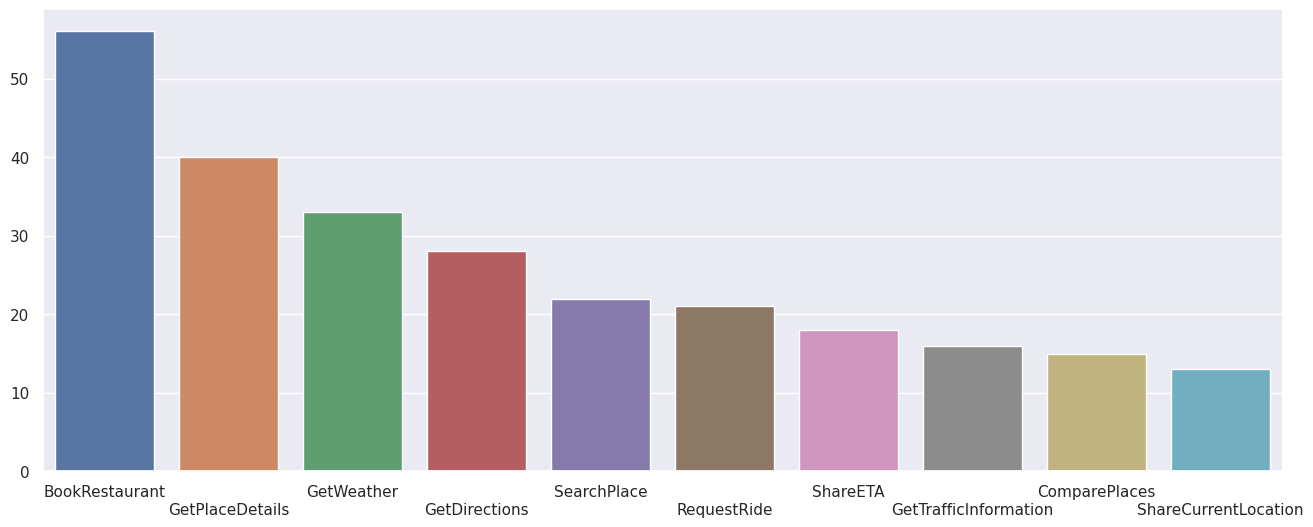

In [ ]:
acts_repartition = {k:0 for k in acts.keys()}
for utterance in dataset['train']:
  acts_repartition[utterance['label']]+=1

sorted_repartition = dict(sorted(acts_repartition.items(), key = lambda x:x[1], reverse=True))

sns.set(rc={'figure.figsize':(16,6)})
plot_x = [(i%2)*"\n"+acts[key] for i, key in enumerate(sorted_repartition.keys())]
sns.barplot(x=plot_x, y=list(sorted_repartition.values()), width = .8)#.tick_params(labelsize=5)

In [ ]:
longuest_utt_chars = 0
for split in dataset:
  for utterance in dataset[split]:
    if len(utterance['text']) > longuest_utt_chars:
      longuest_utt_chars = len(utterance['text'])

print(f"The longuest utterance in the dataset is {longuest_utt_chars} characters long")
                             

The longuest utterance in the dataset is 93 characters long


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/262 [00:00<?, ? examples/s]

Map:   0%|          | 0/66 [00:00<?, ? examples/s]

In [ ]:
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=len(acts))

RUN THE FOLLOWING CELL IF YOU WANT TO LOAD THE TRAINED MODEL

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('./model_NLP')

In [ ]:
training_args = TrainingArguments(output_dir="test_trainer", 
                                  evaluation_strategy="epoch",
                                  save_strategy = "epoch",
                                  num_train_epochs=5,
                                  load_best_model_at_end=True,
                                  weight_decay=0.01,
                                  #per_device_train_batch_size=1,
                                )

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    compute_metrics=compute_metrics,
)

SKIP THE FOLLOWING CELL IF YOU LOADED THE TRAINED MODEL

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.498404,0.530303
2,No log,0.814846,0.833333
3,No log,0.446736,0.909091
4,No log,0.335705,0.893939
5,No log,0.281089,0.909091


TrainOutput(global_step=165, training_loss=0.799818096738873, metrics={'train_runtime': 162.2148, 'train_samples_per_second': 8.076, 'train_steps_per_second': 1.017, 'total_flos': 344700240138240.0, 'train_loss': 0.799818096738873, 'epoch': 5.0})

In [ ]:
trainer.save_model('./model_NLP')

NO NEED TO RUN THE FOLLOWING PARTS, WE WILL DIRECTLY LOAD THE BACK TRANSLATED DATASET

In [ ]:
!pip install --upgrade deepl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import deepl

class Translator:
  def __init__(self):
    auth_key = "YOU API KEY HERE"
    self.translator = deepl.Translator(auth_key)

  def translate(self, utt, target_lang):
    return self.translator.translate_text(utt, target_lang=target_lang).text

  def backtrad(self, utt, current_lang="EN-US", target_lang="FR"):
    trad_txt = self.translator.translate_text(utt["text"], target_lang=target_lang).text
    utt["text"] = self.translator.translate_text(trad_txt, target_lang=current_lang).text
    return utt

In [ ]:
trad = Translator()

backtrans_data = dataset.map(trad.backtrad, batched=False)
print(backtrans_data['train'][:10])

In [ ]:
#To save translated dataset (Only need to use DeepL's API once)
backtrans_data_train = []
for utt in backtrans_data['train']:
  backtrans_data_train.append(utt)

pick_insert = open('drive/My Drive/NLP_backtrans_dataset_train.pickle','wb')
pickle.dump(backtrans_data_train, pick_insert)
pick_insert.close()

backtrans_data_test = []
for utt in backtrans_data['test']:
  backtrans_data_test.append(utt)

pick_insert = open('drive/My Drive/NLP_backtrans_dataset_test.pickle','wb')
pickle.dump(backtrans_data_test, pick_insert)
pick_insert.close()



RUN TO LOAD BACK TRANSLATED DATASET

In [ ]:
#run to load dataset
pick_read =   open('drive/My Drive/NLP_backtrans_dataset_train.pickle','rb')
data_train = pickle.load(pick_read)
pick_read.close()
translated_train_dataset = Dataset.from_pandas(pd.DataFrame(data=data_train))
tokenized_train_translated_dataset = translated_train_dataset.map(tokenize_function, batched=True)
print(tokenized_train_translated_dataset[:10])
print(tokenized_dataset['train'][:10])

#run to load dataset
pick_read =   open('drive/My Drive/NLP_backtrans_dataset_test.pickle','rb')
data_test = pickle.load(pick_read)
pick_read.close()
translated_test_dataset = Dataset.from_pandas(pd.DataFrame(data=data_test))
tokenized_test_translated_dataset = translated_test_dataset.map(tokenize_function, batched=True)
print(tokenized_test_translated_dataset[:10])
print(tokenized_dataset['test'][:10])

Map:   0%|          | 0/262 [00:00<?, ? examples/s]

{'text': ['Reserve a table for Sophie and I at Red Lobster tonight.', "Tell my friends what time I'll be there", 'Make a reservation for 4 people for lunch today at a nearby Starbucks.', 'I want the weather in Paris', 'Find me an outdoor table at Five leaves for 3', "I need a cab for 6 people to go to Audrey and Sam's wedding.", "Reserve a table for Friday 8pm for 2 people at Katz's Delicatessen", "Show me the way to Rand's birthday party by car", 'Find me a place in Ippudo for lunch.', 'Is there a wifi at Smile?'], 'label': [7, 9, 7, 2, 7, 1, 7, 8, 7, 4], 'input_ids': [[101, 5081, 170, 1952, 1111, 7800, 1105, 146, 1120, 2156, 10605, 4832, 2083, 3568, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Map:   0%|          | 0/66 [00:00<?, ? examples/s]

{'text': ['I want to see pictures of where we are going tonight.', "Find me a romantic restaurant that serves good, expensive wine near my girlfriend's workplace.", 'Will it be cloudy at my Facebook event?', 'What will the weather be like in London next week?', 'Is The View more expensive than Masa?', 'Share my ETA with Mary Jane', "Book a cab to Sebastian's house", 'Should I expect traffic to meet my friends tonight?', 'Send my current position to my father', 'Order a cab for tomorrow 8 am'], 'label': [4, 3, 2, 2, 0, 9, 1, 6, 5, 1], 'input_ids': [[101, 146, 1328, 1106, 1267, 5324, 1104, 1187, 1195, 1132, 1280, 3568, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

WE WILL THEN TRAIN BERT ON THE BACK TRANSLATED DATASET

In [ ]:
backtrans_model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=len(acts))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
backtrans_model = AutoModelForSequenceClassification.from_pretrained('./backtrans_model_NLP')

In [ ]:
backtrans_trainer = Trainer(
    model=backtrans_model,
    args=training_args,
    train_dataset=tokenized_train_translated_dataset,
    eval_dataset=tokenized_test_translated_dataset,
    compute_metrics=compute_metrics,
)

SKIP THIS CELL IF YOU LOADED THE TRAINED BACKTRANS_MODEL

In [ ]:
backtrans_trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.666281,0.515152
2,No log,0.989778,0.772727
3,No log,0.580307,0.893939
4,No log,0.386519,0.924242
5,No log,0.320747,0.939394


TrainOutput(global_step=165, training_loss=0.9669073856238163, metrics={'train_runtime': 161.9916, 'train_samples_per_second': 8.087, 'train_steps_per_second': 1.019, 'total_flos': 344700240138240.0, 'train_loss': 0.9669073856238163, 'epoch': 5.0})

In [ ]:
backtrans_trainer.save_model('./backtrans_model_NLP')

WE WILL NOW EVALUATE GENERALIZATION CAPABILITES OF BOTH MODELS

In [ ]:
backtrans_trainer.evaluate(eval_dataset=tokenized_dataset['test'])

{'eval_loss': 0.3378109931945801,
 'eval_accuracy': 0.9545454545454546,
 'eval_runtime': 2.2937,
 'eval_samples_per_second': 28.774,
 'eval_steps_per_second': 3.924}

In [ ]:
trainer.evaluate(eval_dataset=tokenized_test_translated_dataset)

{'eval_loss': 0.2787693440914154,
 'eval_accuracy': 0.9090909090909091,
 'eval_runtime': 2.2699,
 'eval_samples_per_second': 29.077,
 'eval_steps_per_second': 3.965}

WE WILL PLOT CONFUSION MATRIXES

In [ ]:
def plot_cf_matrix(pred, truth, classes):
  cf_matrix = sklearn.metrics.confusion_matrix(truth, pred)
  disp = sklearn.metrics.ConfusionMatrixDisplay(cf_matrix, display_labels=classes)
  disp.plot()


In [ ]:
pred = trainer.predict(test_dataset=tokenized_dataset['test'])
backtrans_pred = backtrans_trainer.predict(test_dataset=tokenized_test_translated_dataset)

labels_pred = []
labels_pred_backtrans = []
for i in range(val_dataset.shape[0]): #pred_backtrans.label_ids):
  labels_pred_backtrans.append(np.argmax(backtrans_pred.predictions[i]))
  labels_pred.append(np.argmax(pred.predictions[i]))

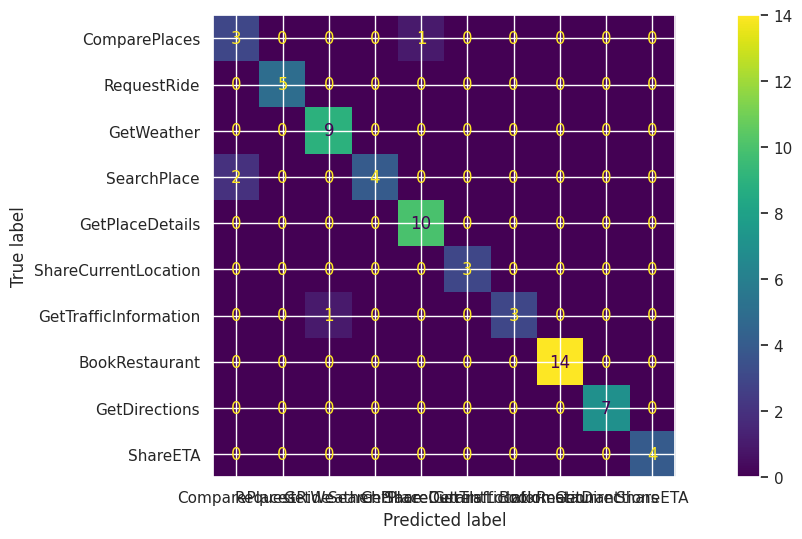

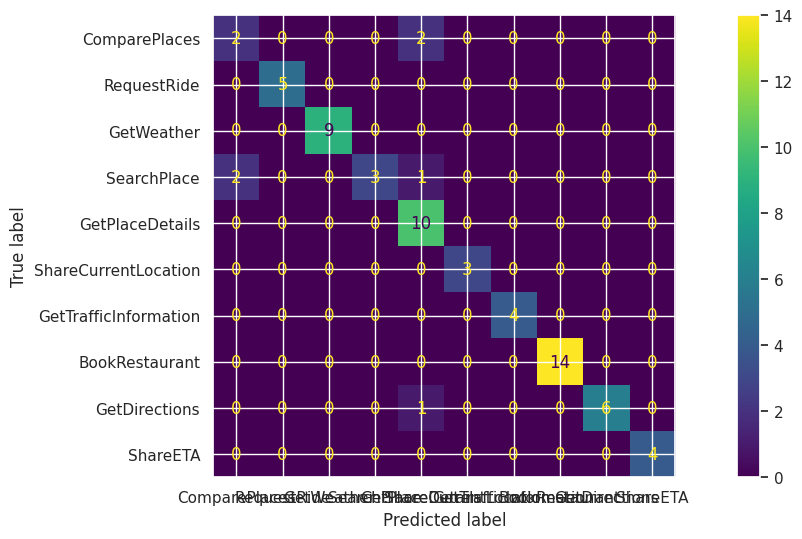

In [ ]:
print("Confusion matrix of the model trained with back translation step")
plot_cf_matrix(labels_pred_backtrans, pred.label_ids, acts.values())

print("Confusion matrix of the model trained without back translation step")
plot_cf_matrix(labels_pred, pred.label_ids, acts.values())